In [271]:
import numpy as np
from scipy.stats import norm, chi2, chi2_contingency, chisquare
import matplotlib.pyplot as plt

In [272]:
# Sample mean
mu_A = 60
mu_B = 62
# Sample std
s_A = 40
s_B = 45
# Sample num
n_A = 6000
n_B = 4000
## Sample target (conversion rate %)
#cr_A = 1.5
#cr_B = 2

# Z-test (or Welch's T-test really..), for continuous variable.

The goal here is to determine if group A spends less time on average than group B. This is done using the Z-test, which is suitable for higher sample sizes (often n>30 per group is cited), as it has to hold that the sample means/stds are sufficiently close to the true mean/stds which may not be the case for lower sample sizes. In any case, our hypothesis are as follows:

$H_0$: average time spent for group A is the same as the average time spent for group B.

$H_1$: average time spent for group A is less than that of group B.

Via central limit theorem the mean for A and B can be approximated as

$$\mu(n_A, A) \sim N\bigg(\mu_A, \frac{\sigma_A^2}{n_A}\bigg)$$
$$\mu(n_B, B) \sim N\bigg(\mu_B, \frac{\sigma_A^2}{n_B}\bigg)$$

Under $H_0$ we have that $\mu_A - \mu_B = 0$, thus we can write

$$\mu(n_A, A) - \mu(n_B, B) \sim N\bigg(\mu_A - \mu_B, \frac{\sigma_A^2}{n_A} + \frac{\sigma_B^2}{n_B}\bigg) = N\bigg(0, \frac{\sigma_A^2}{n_A} + \frac{\sigma_B^2}{n_B}\bigg)$$

$$ \implies \frac{\mu(n_A, A) - \mu(n_B, B)}{\sqrt{\frac{\sigma_A^2}{n_A} + \frac{\sigma_B^2}{n_B}}} \sim N(0, 1)$$

This is the Z-statistic, but when $\mu_A$, $\mu_B$, $\sigma_A$ and $\sigma_B$ are approximated via those of their respective samples. 

To clarify, if $a_i$ is one realization of time taken within group A then

$$\mu_A \approx \frac{1}{n_A} \sum_i a_i = \hat{\mu_A}$$
$$\sigma_A \approx \frac{1}{n_A} \sum_i (\hat{\mu_A} - a_i)^2 = \hat{\sigma_A}$$

So we have

$$Z \approx \frac{\hat{\mu_B} - \hat{\mu_A}}{\sqrt{\frac{\hat{\sigma_A}^2}{n_A} + \frac{\hat{\sigma_B}^2}{n_B}}}$$

For the alternative hypothesis to hold we expect a positive value of Z in this case. The Z-value be interpreted as number of standard deviations the difference of means is from 0, so higher Z implies lower likelihood of $H_0$.



Note that this is using unpooled variances and is not following the assumption that the means are equal, as that also implies the sigmas are equal as we know that $\sigma^2 = \mu*(1-\mu)$ for Bernoulli distributions. By using unpooled variances we are conducting Welch's T-test, where the variances are not assumed to be equal in A and B. But from our null hypothesis

$$\sigma^2 = \mu(1-\mu)$$


$$Z \approx \frac{\hat{\mu_B} - \hat{\mu_A}}{\sqrt{\sigma^2(\frac{1}{n_A} + \frac{1}{n_B})}}$$

In [259]:
# Unpooled variance, aka Welch's T-test
Z = (mu_B - mu_A)/(np.sqrt((s_A**2)/n_A + (s_B**2)/n_B))

p = 1-norm.cdf(Z)
print(f"Z-value is: {Z}")
print(f"p is: {np.round(p,4)}, thus null hypothesis is rejected for alpha = 5%")

Z-value is: 2.2749070654279993
p is: 0.0115, thus null hypothesis is rejected for alpha = 5%


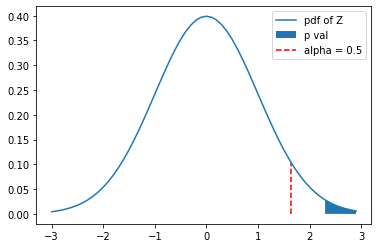

In [78]:
z = np.arange(-3, 3, 0.1)
plt.plot(z, norm.pdf(z), label = 'pdf of Z')  
plt.fill_between(z[z > Z], norm.pdf(z[z > Z]), label='p val') # TODO: switch alpha to fill and z to vline because it's stupid to have it this way
plt.vlines([norm.ppf(0.95)], ymin=0, ymax=norm.pdf(norm.ppf(0.95)), linestyles='dashed', label='alpha = 0.5', color='red')
plt.legend()

### Confidence interval
We can also compute the confidence interval for the mean via

$$CI = \bar{\mu} \pm z^*\frac{s}{\sqrt{n}}$$

where $\bar{\mu}$ is the sample mean, $s$ is the sample standard deviation and $n$ the sample size. $z^*$ is the appropriate z-value from a standard normal distribution table for the desired confidence interval. $z^* = 1.96$ yields a 95% confidence interval, as 1.96 standard deviations cover 95% of the area of the pdf.

Notably there is quite some bit of overlap in the confidence intervals.

[58.98786035219113, 61.01213964780887]

[60.605435551865746, 63.394564448134254]

(0.9, 1.2, 57.975720704382255, 64.78912889626851)

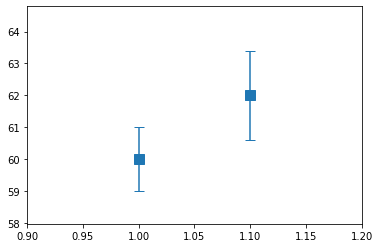

In [250]:
err_A = 1.96*s_A/np.sqrt(n_A)
err_B = 1.96*s_B/np.sqrt(n_B)
CI_A = [mu_A-err_A, mu_A+err_A]
CI_B = [mu_B-err_B, mu_B+err_B]

display(CI_A)
display(CI_B)


plt.errorbar(x=[1, 1.1], y=[mu_A, mu_B], yerr=[err_A, err_B], capsize=5, markersize=10, marker="s", ls='none')
plt.axis([0.9, 1.2, mu_A-err_A*2, mu_B+err_B*2])

# Chi^2 test for conversion rate.

$H_0$: Conversion rate is the same.

$H_1$: Conversion rate is lower or higher in B.

Under $H_0$ conversion rate should be 

$$cr_{exp} = \frac{conv_A + conv_B}{conv_A + nonconv_A + conv_B + nonconv_B}$$

Which can be used to compute expected conversions in both A and B, for example

$$conv_{A,expected} = cr_{exp} \cdot n_A$$

Then the RV defined as

$$D = \sum_{conv \in \{0,1\}, sample \in \{A, B\}} \frac{(O_{sample, conv} - T_{sample, conv})^2}{T_{sample,conv}}  $$

Follows a Chi squared distribution with 1 degree of freedom (computed by len([conv, nonconv] - 1)). If $H_0$ is true the relative squared difference described in $D$ should be small.



In [183]:
# Observed
conv_A = 90
nonconv_A = 5910

conv_B = 80
nonconv_B = 3920

# Expected
cr_exp = (conv_A+conv_B) / (n_A + n_B)

conv_A_exp = int(cr_exp*n_A)
nonconv_A_exp = n_A-conv_A_exp

conv_B_exp = int(cr_exp*n_B)
nonconv_B_exp = n_B-conv_B_exp

In [299]:
# Compute D
T = np.array([conv_A_exp, conv_B_exp, nonconv_A_exp, nonconv_B_exp])
O = np.array([conv_A, conv_B, nonconv_A, nonconv_B])

D = np.sum(np.square([T - O])/T)
pval = (1-chi2.cdf(D, df=1))/2

print(f"p is: {np.round(pval,4)/1}, thus null hypothesis is rejected for alpha = 5%. p value is adjusted by 0.5 here due to only testing one side in the non squared distribution")

p is: 0.0291, thus null hypothesis is rejected for alpha = 5%. p value is adjusted by 0.5 here due to only testing one side in the non squared distribution


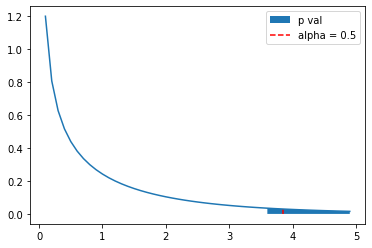

In [300]:
d = np.arange(0, 5, 0.1)
plt.plot(d, chi2.pdf(d, df=1))
plt.fill_between(d[d>D], chi2.pdf(d[d>D], df=1), label='p val')
plt.vlines([chi2.ppf(0.95,df=1)], ymin=0, ymax=chi2.pdf(chi2.ppf(0.95,df=1),df=1), linestyles='dashed', label='alpha = 0.5', color='red')
plt.legend()
plt.show()

This plot is a bit off, with no adjustments due to the two-sidedness of the chi squared test. For a two sided test we would reject the hypothesis, but this does not describe the problem we are actually solving. To be fixed at some point..

In [269]:
# Z-test for conversion, nonpooled var
# Sample mean
mu_A_conv = conv_A/n_A
mu_B_conv = conv_B/n_B
# Sample std
s_A_conv = mu_A_conv*(1-mu_A_conv)
s_B_conv = mu_B_conv*(1-mu_B_conv)

Z_conv = (mu_B_conv - mu_A_conv)/np.sqrt(s_B_conv/n_B + s_A_conv/n_A)

p_conv = 1-norm.cdf(Z_conv)
print(f"p is: {np.round(p_conv,4)}, thus null hypothesis is rejected for alpha = 5%. Not using pooled variance.")

p is: 0.0327, thus null hypothesis is rejected for alpha = 5%. Not using pooled variance.


In [304]:
# Z-test for conversion, pooled var
# Sample mean
mu_A_conv = conv_A/n_A
mu_B_conv = conv_B/n_B
# Var (pooled)
var = cr_exp*(1-cr_exp)*(1/n_A + 1/n_B)

Z_conv = (mu_B_conv - mu_A_conv)/np.sqrt(var)

p_conv = 1-norm.cdf(Z_conv)
print(f"p is: {np.round(p_conv,4)}, thus null hypothesis is rejected for alpha = 5%. Using \"exact\" variance computed from population mean of both A and B.")

p is: 0.0291, thus null hypothesis is rejected for alpha = 5%. Using "exact" variance computed from population mean of both A and B.
